<a href="https://colab.research.google.com/github/anthonymelson/portfolio/blob/master/Breast_Cancer_Probabilistic_v_Label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [0]:
#Dataset
from sklearn.datasets import load_breast_cancer

#Data Manipulation
import pandas as pd
import numpy as np

#Plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Model Training 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFpr, chi2
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

#Scoring and Evaluation
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, balanced_accuracy_score, log_loss, f1_score, recall_score, confusion_matrix, precision_score, accuracy_score

#Style and Plotting
%matplotlib inline
plt.style.use('fivethirtyeight')

## **Load Data**

In [56]:
X, y = load_breast_cancer(return_X_y=True)
data = load_breast_cancer()
feature_names = data.feature_names
X.shape

(569, 30)

## Feature Selection Outline

**Number of Features and Approach**

Since there are 30 features, it is difficult to visualize them in any meaningful way.  Though this route could be accomodated, the intension is to use a wrapper method with strong regularization anyways.  So the goal of this exploritory analysis will be to establish that there are features in the set that are related to the target, and if so, how many there are.

**Feature Importances and Mutual Information**

To do this, feature importances will be extracted from a fit random forest classifier, and mutual information between the features and target will be measured.  Features will be ranked for both of these values.

**Filter Method (Variance Threshold) and Wrapper Method (LassoCV)**

After this is completed, the full feature set will be brought back, features with low variance will be dropped and several Lasso Regressions with strong regularization will be fit to the data, and the features contained in the best performing model among them will be used to build the Logistic Regression.

**Visual Confirmation of Relationships**

However, prior to fitting the model, the smaller feature set will be visualized using box plots and pair plots to verify the selection of the wrapper and filter methods visually.

### Feature Importances w/RandomForestClassifier

*  Fit random forest classifier with 50 estimators (trees) and a max depth of 10 (nodes between starting node and terminal nodes (leaves).
*  Retrieve feature importances from fit model
*  Rank the features by importance
*  Select only those features that have importance above 0.08 (where the sum of *all* the features = 1.0)

In [0]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=74).fit(X, y)
fi = clf.feature_importances_
df = pd.DataFrame(fi, feature_names)
df['FI_Rank'] =  df[0].rank(ascending=False)

df = df.reset_index()
df = df.rename(columns={'index': 'FeaturesFI', 0:"Feature Importance"})
df = df.sort_values('FI_Rank', ascending=True)
df1 = df[df['Feature Importance'] > 0.08]
df1_best = list(df1.index)

### Mutual Information w/Mutual_Info_Classif

*  Determine mutual information of all features with target.
*  Rank the features by mutual information
*  Select only those features that have mutual information above 0.4 (where the highest possible score for *each* feature is 1.0)

In [0]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X,y, random_state=157)
df = pd.DataFrame(mi, feature_names)
df['MI_Rank'] =  df[0].rank(ascending=False)

df = df.reset_index()
df = df.rename(columns={'index': 'FeaturesMI', 0:"Mutual Information"})
df = df.sort_values('MI_Rank', ascending=True)
df2 = df[df['Mutual Information'] > 0.4]
df2_best = list(df2.index)

#### Join the Two

Use a join to combine the two dataframes, and keep only the features that are above the given thresholds for both.


In [59]:
features = df1.join(df2).drop(['FeaturesMI'], axis=1)
display(features)


,FeaturesFI,Feature Importance,FI_Rank,Mutual Information,MI_Rank
27,worst concave points,0.142614,1.0,0.436514,5.0
22,worst perimeter,0.130170,2.0,0.473275,1.0
7,mean concave points,0.124734,3.0,0.441447,4.0
23,worst area,0.098240,4.0,0.463845,2.0



This provides a great deal of insight into the set.  Both of these methods do well at accounting for simple and complex relationships and in two very different ways.

This gives a good idea of the number of features that should be selected.  If the data set were larger (i.e. difficult to use a wrapper method on), these results would be sufficient to move forward.  However, a wrapper method is viabale, and will be applied next.

#### Variance Threshold

Starting with the full data set, remove all features that have variance below 0.0009.  This will eliminate features that couldn't possibly have anything to offer, and in turn, improve the performance and speed of the wrapper method.

In [61]:
sel = VarianceThreshold(threshold=0.0009)
sel.fit(X)
X = sel.transform(X)
X.shape

(569, 20)

### Select From Model (LassoCV)

Now that 10 low variance features have been removed, several LassoCV models can be fit, and a model can be selected from it.  LassoCV is being selected for three reasons:
1.  It has strong regularization
2.  It is different from the model that will be deployed in the final version, which is preferable.  Otherwise there would be no reason to think these features had any stronger relationship to the target than the model performance would indicate.

In [62]:
clf = LassoCV(cv=5).fit(X, y)
sfm = SelectFromModel(clf, threshold=0.00001)
sfm.fit(X, y)
X = sfm.transform(X)
X.shape

(569, 4)

## Visualize Selected Features

Now that there are only four features, they can be easily visualized.  Though the analyses above are sufficient, this will allow for one last check to make sure the selected features have sufficiently strong relationships with the target to build a reliable model.

### Pair Plots w/Seaborn (Scatter & Distributions)

First, a pair plot can be used to see how the features are distributed in relation to the target, and how well they do in separating the malignant from the benign.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


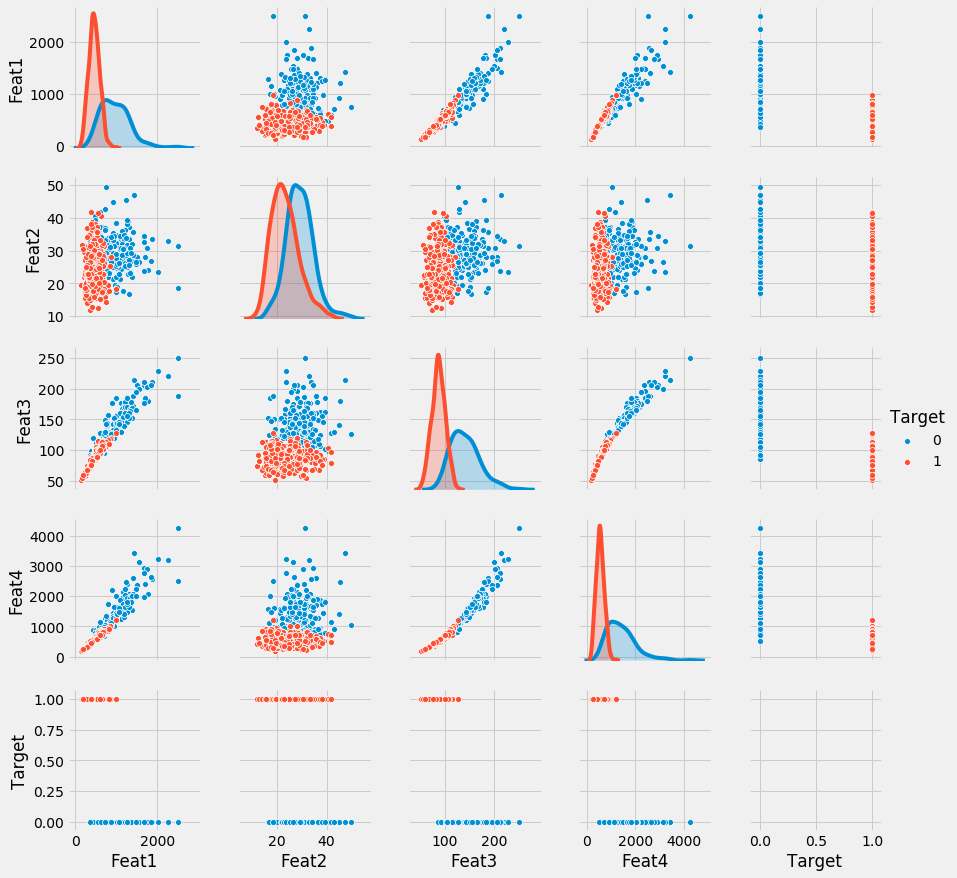

In [63]:
Xy = pd.DataFrame(X, columns=['Feat1', 'Feat2', 'Feat3', 'Feat4'])
yy = pd.DataFrame(y)
Xy['Target'] = yy[0]

pp = sns.pairplot(data=Xy, hue="Target")

### Box Plots (Features vs Target)

The pair plots look good.  The features are clearly related to the target, and should do well in the classification model.  However, with the large number of data points, it is a bit difficult to see how well the two classes are separated.  Boxplots will be able to further clarify this.

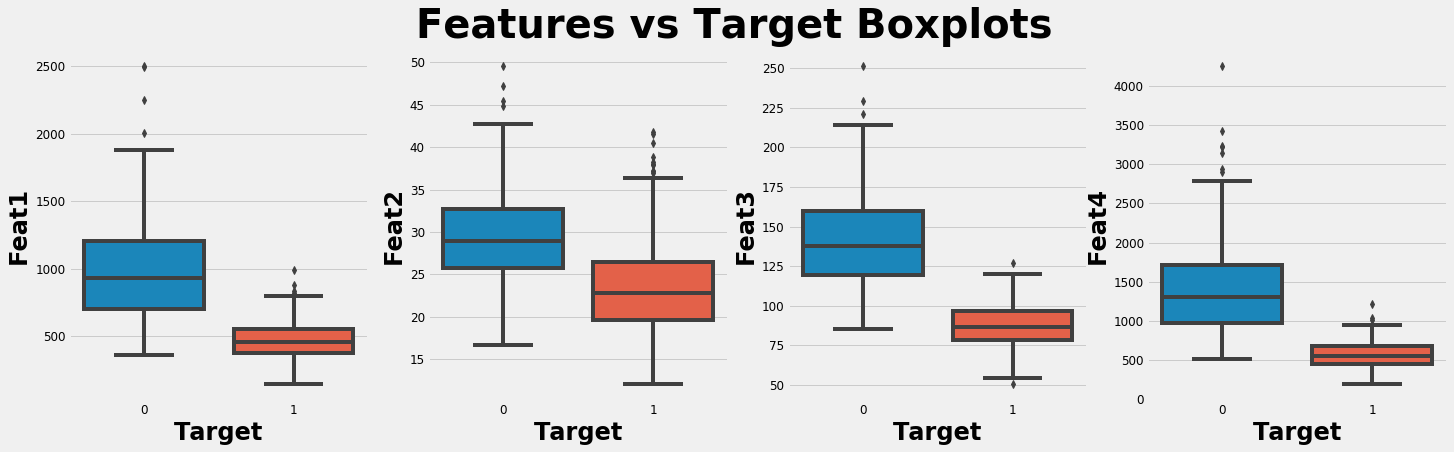

In [64]:
fig, axs = plt.subplots(1, 4)
fig.set_figheight(6)
fig.set_figwidth(22)
fig.suptitle("Features vs Target Boxplots", fontsize=40, fontweight='bold')
one = sns.boxplot(data=Xy, x='Target', y='Feat1', orient='v', ax=axs[0])
one.set_xlabel("Target",fontsize=24, fontweight='bold')
one.set_ylabel("Feat1",fontsize=24, fontweight='bold')
one.tick_params(labelsize=12)
two = sns.boxplot(data=Xy, x='Target', y='Feat2', orient='v', ax=axs[1])
two.set_xlabel("Target",fontsize=24, fontweight='bold')
two.set_ylabel("Feat2",fontsize=24, fontweight='bold')
two.tick_params(labelsize=12)
three = sns.boxplot(data=Xy, x='Target', y='Feat3', orient='v', ax=axs[2])
three.set_xlabel("Target",fontsize=24, fontweight='bold')
three.set_ylabel("Feat3",fontsize=24, fontweight='bold')
three.tick_params(labelsize=12)
four = sns.boxplot(data=Xy, x='Target', y='Feat4', orient='v', ax=axs[3])
four.set_xlabel("Target",fontsize=24, fontweight='bold')
four.set_ylabel("Feat4",fontsize=24, fontweight='bold')
four.tick_params(labelsize=12)
plt.show()

The box plots look fantastic.  There is clearly a significant difference between the two classes within for each feature. Specifically, 3 and 4, appear to have a large enough difference to be established by a mean difference test (though this will not be necessary).

## Data Split and Parameter Selection w/LogisticRegression

The data is split (70% training, 30% test)

In [0]:
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.3, random_state=105)

To find the optimal parameters, a logistic regression will be fit, and a parameter grid search used.  This will fit a model for each possible combination within the parameter grid.  

The combinations of interest will be the regulariation strength (CS), the type of solver (solver), and the class weights (class weight).  The first two are always of interest with a regularized logistic regression, the third, however, is of specific interest because the target is imbalanced (meaning there are more observations of one class than the other).

In [0]:
Log_Reg_Param = LogisticRegressionCV(cv=1)

param_grid = {
    'Cs': [1,2,3,4,5,6,7,8,9],
    'cv': [5],
    'random_state': [310],
    'penalty': ["l2"],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced', 'None']
}

#### Get Best Parameters and Train Final Model

Now the grid search is performed, and the optimal parameters are extracted from it and viewed.

In [0]:
Param_List = GridSearchCV(estimator=Log_Reg_Param, param_grid=param_grid, cv=5).fit(X, y)
Best_Params = Param_List.best_params_
Best_Params

In [68]:
LR = LogisticRegressionCV(**Best_Params).fit(X, y)
LR

LogisticRegressionCV(Cs=8, class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=310, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Now the optimal parameters and features are used to fit a linear regression model.  This model is hoped to be the final model, but will require a great deal of scrutiny (and validation) before that can be determined.

In [69]:

pd.DataFrame(LR.coef_, columns=['Feat1', 'Feat2', 'Feat3', 'Feat4'])

,Feat1,Feat2,Feat3,Feat4
0,0.0141,-0.185736,-0.122609,-0.013462


Now that the model is fit, the coefficients can be extracted and viewed.

## Model Evaluation
Now that the model is built, it can be evaluated.  This will come in multiple steps:

1.  Bias-variance trade-off with learning curve
2.  Probabilistic outputs with Brier Score, Brier Skill Score, Log-Loss, and calibration plot
3.  Label outputs with confusion matrix, precision, accuracy, recall...
4.  Overall model health with a AUC and ROC curve, also revealing the possible trade-off points between precison and recall

After these tests, it will be clear whether the model is well designed and properly performing.  In addition, it will give the reader some insight into the differences between probabilistic outputs and label outputs, which will be expounded on after the tests.

### Plot Learning Curve

Here, the learning curve is checked.  This confirms that there is a good bias-variance trade-off and that the model has not over-fit to the training data.  The scores of the training and test sets converge nicely, showing that the trade-off is good.  

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


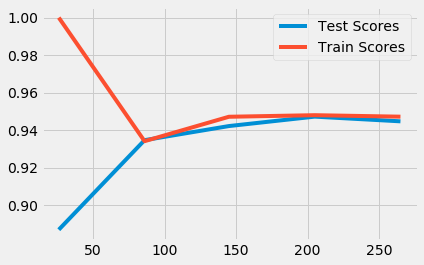

In [70]:
from sklearn.model_selection import learning_curve
tsa, trs, tes  = learning_curve(LR, X, y)
avg_trs = np.mean(trs, axis=1)
avg_tes = np.mean(tes, axis=1)
plt.figure()
plt.plot(tsa, avg_tes, label='Test Scores')
plt.plot(tsa, avg_trs, label='Train Scores')
plt.legend()
plt.show()

#### Get Label and Probability Predictions Of Test Set

In [0]:
Predicted_Probs = LR.predict_proba(X_test)[:,1]
Predicted_Labels = LR.predict(X_test)

In [0]:
#Convert to DF
y_df = pd.DataFrame(y_test)
#Total Observations
tot_obs = y_df.count()
#Total Minority Class (reference class)
tot_min_class = tot_obs - y_df.sum()
#Base Rate for Minority (Reference) Class = Total Minority Class / Total Observations
min_base_rate = tot_min_class/tot_obs

#### Calculate Brier Scores

In [0]:
ll = log_loss(y_test, Predicted_Probs).round(5)
ll_label = "Log-Loss = {}".format(ll)

bs = brier_score_loss(y_test, Predicted_Probs, pos_label=1).round(5)
bs_label = "Brier Score = {}".format(bs)

min_bss = (1 - (bs/min_base_rate)).round(5)[0]
min_bss_label = "Minority BSS = {}".format(min_bss)

maj_base_rate = y_df.sum()/tot_obs
maj_bss = (1 - (bs/maj_base_rate)).round(5)[0]
maj_bss_label = "Majority BSS = {}".format(maj_bss)

### Create Reliability (Calibration) Plot

In [0]:
true_prob_bin, pred_prob_bin = calibration_curve( y_test, Predicted_Probs,n_bins=5, strategy='quantile', normalize=True)

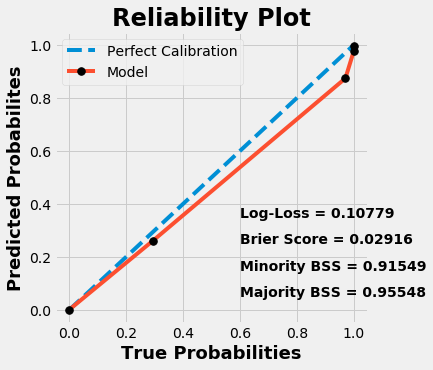

In [75]:
plt.figure(figsize=(5,5))
plt.xlabel('True Probabilities', fontsize=18, fontweight='bold')
plt.ylabel('Predicted Probabilites', fontsize=18, fontweight='bold')
plt.plot([0, 1], [0, 1], label='Perfect Calibration', linestyle='--')
plt.plot(true_prob_bin, pred_prob_bin, label='Model', marker='.', markeredgecolor='black', markerfacecolor='black', markersize='15')
plt.text(0.6, 0.05, maj_bss_label, fontsize=14, fontweight='bold')
plt.text(0.6, 0.15, min_bss_label, fontsize=14, fontweight='bold')
plt.text(0.6, 0.25, bs_label, fontsize=14, fontweight='bold')
plt.text(0.6, 0.35, ll_label, fontsize=14, fontweight='bold')
plt.title('Reliability Plot', fontsize=24, fontweight='bold')
plt.legend(loc='best',fontsize=14)
plt.show()

### Get and Display Scores For Label Output

In [76]:
scores = {
          "Precision":precision_score(y_test, Predicted_Labels),
          "Recall": recall_score(y_test, Predicted_Labels) ,
          "Accuracy": accuracy_score(y_test, Predicted_Labels), 
          "Balanced Accuracy":balanced_accuracy_score(y_test, Predicted_Labels),
          "F1 Score": f1_score(y_test, Predicted_Labels),
          }
pd.DataFrame.from_dict(scores, orient='index', columns=['Scores'])

,Scores
Precision,0.981982
Recall,0.973214
Accuracy,0.970760
Balanced Accuracy,0.969658
F1 Score,0.977578


### Create Confusion Matrix

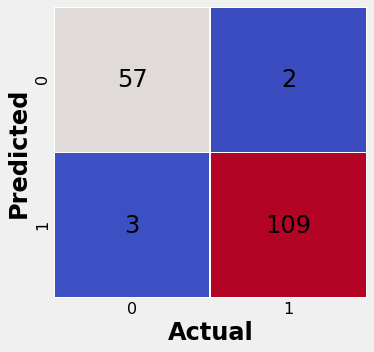

In [77]:
cm = confusion_matrix(y_test, Predicted_Labels)
plt.figure(figsize=(5,5))
ax = sns.heatmap(pd.DataFrame(cm), cmap='coolwarm', annot=True, fmt='d', cbar=False, linecolor='white', linewidths=1, annot_kws={"fontsize":24, "color":'0'})
ax.set_xlabel("Actual",fontsize=24, fontweight='bold')
ax.set_ylabel("Predicted",fontsize=24, fontweight='bold')
ax.tick_params(labelsize=16)
plt.show()

### Calculate AUC and Plot ROC Curve

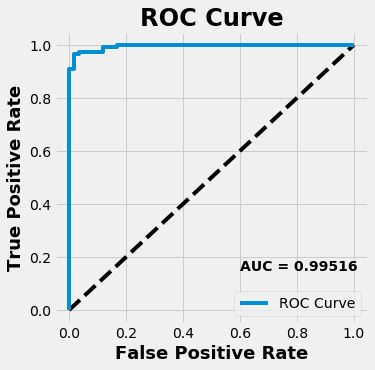

In [78]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, Predicted_Probs, pos_label=1)
AUC = roc_auc_score(y_test, Predicted_Probs).round(5)
AUC_label = "AUC = {}".format(AUC)

plt.figure(figsize=(5,5))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate',fontsize=18, fontweight='bold')
plt.ylabel('True Positive Rate',fontsize=18, fontweight='bold')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.text(0.6, 0.15, AUC_label, fontsize=14, fontweight='bold')
plt.title('ROC Curve', fontsize=24, fontweight='bold')
plt.show()